In [107]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.feature_selection import RFECV

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, roc_auc_score
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

random_seed = 1234 

## TCGA BRCA Data 

In [108]:
def load_ndjson(path):
    try:
        with open(path, 'r') as file:
            obj = [json.loads(line) for line in file]
            return obj
    except json.JSONDecodeError as e:
        print(e)

def subset_dataframe(df, label_col, ratio, seed):
    grouped = df_expression.groupby(label_col)
    subset = grouped.apply(lambda x: x.sample(frac=ratio, random_state=seed)).reset_index(drop=True)
    return subset
    
# different way of loading in data via grip - needs to be normalized & EDA (TODO: data structure observations & query)
# https://github.com/ohsu-comp-bio/embedding-kit/blob/ea432f15e2b12981460ed408e1845ac18bd9f235/scripts/tcga_fetch.py#L10

In [109]:
df = pd.read_csv("../../TMP_20230209/BRCA_v12_20210228.tsv", sep="\t")
df_original = df
# df.dropna(inplace=True) # check for null 

df = df[(~df.iloc[:, 2:].isna().all(axis=1)) & (~(df.iloc[:, 2:] == 0).all(axis=1))]

doc_ref = load_ndjson(path="../../fhir/GDC-FHIR/TCGA-BRCA/META/DocumentReference.ndjson")
patients = load_ndjson(path="../../fhir/GDC-FHIR/TCGA-BRCA/META/Patient.ndjson")
p_map = {}

for patient in patients:
    p_map.update({[_id['value'] for _id in patient['identifier'] if _id['use'] == 'secondary'][0] : patient['id']})
# p_map

In [110]:
count_per_label = df['Labels'].value_counts()
print("counts per label:")
print(count_per_label)

counts per label:
Labels
BRCA_1    535
BRCA_2    205
BRCA_3    175
BRCA_4     80
Name: count, dtype: int64


In [111]:
gexp_cols = [col_name for col_name in list(df.columns) if 'GEXP' in col_name]
df_expression = df[['BRCA', 'Labels'] + gexp_cols]
df_expression.index = df.BRCA
df_expression

,BRCA,Labels,N:GEXP::?:100130426:,N:GEXP::?:100133144:,N:GEXP::?:100134869:,N:GEXP::?:10357:,N:GEXP::?:10431:,N:GEXP::?:136542:,N:GEXP::?:155060:,N:GEXP::?:26823:,...,N:GEXP::ZXDA:7789:,N:GEXP::ZXDB:158586:,N:GEXP::ZXDC:79364:,N:GEXP::ZYG11A:440590:,N:GEXP::ZYG11B:79699:,N:GEXP::ZYX:7791:,N:GEXP::ZZEF1:23140:,N:GEXP::ZZZ3:26009:,N:GEXP::psiTPTE22:387590:,N:GEXP::tAKR:389932:
BRCA,,,,,,,,,,,,,,,,,,,,,
TCGA-3C-AAAU,TCGA-3C-AAAU,BRCA_1,0.0000,16.3640,12.9320,52.150,408.08,0,1187.00,0.0000,...,129.590,1007.80,1658.50,258.490,1208.40,3507.2,1894.90,1180.50,1.7233,0.0000
TCGA-3C-AALI,TCGA-3C-AALI,BRCA_4,0.0000,9.2659,17.3790,69.755,563.89,0,516.04,1.0875,...,59.815,448.61,1343.10,198.480,603.59,5504.6,1318.70,406.74,926.5900,0.0000
TCGA-3C-AALJ,TCGA-3C-AALJ,BRCA_2,0.9066,11.6230,9.2294,154.300,1360.80,0,592.02,0.0000,...,35.358,534.00,768.81,331.820,532.18,5458.8,942.88,509.52,35.3580,0.0000
TCGA-3C-AALK,TCGA-3C-AALK,BRCA_1,0.0000,12.0890,11.0800,143.860,865.54,0,552.75,0.4137,...,55.027,437.73,863.88,175.420,607.37,5691.4,781.13,700.87,66.6120,0.0000
TCGA-4H-AAAK,TCGA-4H-AAAK,BRCA_1,0.0000,6.8468,14.4300,84.213,766.38,0,260.85,0.4255,...,48.936,424.25,1049.80,14.043,775.75,4041.7,831.91,881.70,187.2300,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44,TCGA-WT-AB44,BRCA_1,0.0000,0.0000,3.2580,42.264,1877.40,0,704.54,4.0725,...,24.435,243.53,772.96,98.554,315.21,10937.0,800.65,443.09,724.9000,0.0000
TCGA-XX-A899,TCGA-XX-A899,BRCA_1,0.0000,14.3860,21.4410,137.780,652.76,0,427.17,2.7559,...,70.866,643.70,1266.50,21.260,688.19,5118.1,1933.90,670.08,98.4250,0.0000
TCGA-XX-A89A,TCGA-XX-A89A,BRCA_1,0.0000,22.3240,27.2740,64.143,722.72,0,376.48,0.4724,...,48.654,341.52,1375.50,164.380,746.81,5477.6,1437.40,953.71,235.2400,0.9447


## Feature Engineering

In [112]:
# decided not to do this 
# subset_ratio = 0.20
# df_subset = subset_dataframe(df_expression, label_col='Labels', ratio=subset_ratio, seed=random_seed)

# # print("original df_expression:")
# # print(df_expression)
# # print("\nsubset df:")
# # print(df_subset)

# count_per_label = df_subset['Labels'].value_counts()
# print("counts per label:")
# print(count_per_label)

In [113]:
def train_test_dat(_df, cols=['BRCA', 'Labels']):
    _df['Labels'] = _df['Labels'].astype('category').cat.codes 
    X = _df.drop(columns=cols)
    y = _df['Labels']
    return X, y

X, y = train_test_dat(df_expression, cols=['BRCA', 'Labels'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1010)

# encode the categorical variables with leave-one-out encoder ~one hot encoding
encoder = ce.LeaveOneOutEncoder(return_df=True)
X_train_loo = encoder.fit_transform(X_train, y_train)
X_test_loo = encoder.transform(X_test)

In [114]:
clf = RandomForestClassifier(random_state=1010, class_weight="balanced")
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(10), scoring='roc_auc')

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    # ('feature_selection', rfecv),
    ("classifier", clf)

])

param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    # 'classifier__max_features': ['auto', 'sqrt', 'log2'],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

# StratifiedKFold(10)
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=2) # define grid
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1) # TODO: "roc_auc" errors 
grid_search.fit(X_train_loo, y_train) # fit model


# best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best cross-validation score:  0.8879310344827586


In [115]:
# predict on the test set
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_loo)

# evaluate the model - performs well on self (can utilize other resources)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("ROC AUC Score on test data: ", roc_auc)

ROC AUC Score on test data:  0.9772624458289029


In [116]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_1_10_100,"{'classifier__max_depth': 10, 'classifier__min...",1,0.887931,0.018623
10_2_5_200,"{'classifier__max_depth': 10, 'classifier__min...",2,0.883621,0.023078
10_4_10_100,"{'classifier__max_depth': 10, 'classifier__min...",2,0.883621,0.024636
None_4_10_100,"{'classifier__max_depth': None, 'classifier__m...",4,0.882184,0.021504
30_4_10_100,"{'classifier__max_depth': 30, 'classifier__min...",4,0.882184,0.021504
...,...,...,...,...
30_1_2_200,"{'classifier__max_depth': 30, 'classifier__min...",102,0.864943,0.029932
None_1_2_200,"{'classifier__max_depth': None, 'classifier__m...",102,0.864943,0.029932
20_1_2_300,"{'classifier__max_depth': 20, 'classifier__min...",106,0.863506,0.028664


In [117]:
feature_importance = grid_search.best_estimator_.named_steps.classifier.feature_importances_
importance_df = pd.DataFrame({'features': X_train.columns,
                              'importance': feature_importance})
importance_df.sort_values(by='importance', ascending=False, inplace=True)
importance_df

,features,importance
17109,N:GEXP::SPDEF:25803:,0.009891
19652,N:GEXP::XBP1:7494:,0.009724
6598,N:GEXP::FOXC1:2296:,0.008527
10995,N:GEXP::MLPH:79083:,0.006830
83,N:GEXP::ABCC11:85320:,0.006132
...,...,...
7378,N:GEXP::GPRASP2:114928:,0.000000
7377,N:GEXP::GPRASP1:9737:,0.000000
7376,N:GEXP::GPR98:84059:,0.000000
7375,N:GEXP::GPR97:222487:,0.000000


Text(0.5, 0, 'Hyperparameter combinations')

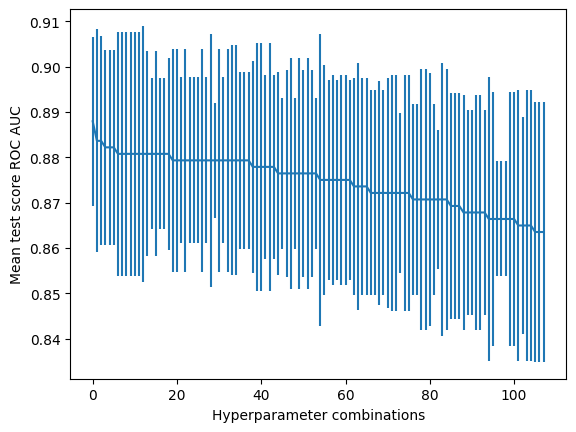

In [118]:
results_df.sort_values(by='mean_test_score', ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

# model performance and the generalization error
results_df['mean_test_score'].plot(yerr=[results_df['std_test_score'], results_df['std_test_score']], subplots=True)
plt.ylabel('Mean test score ROC AUC')
plt.xlabel('Hyperparameter combinations')

In [119]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_loo)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
float(rmse)

0.4404315305588008

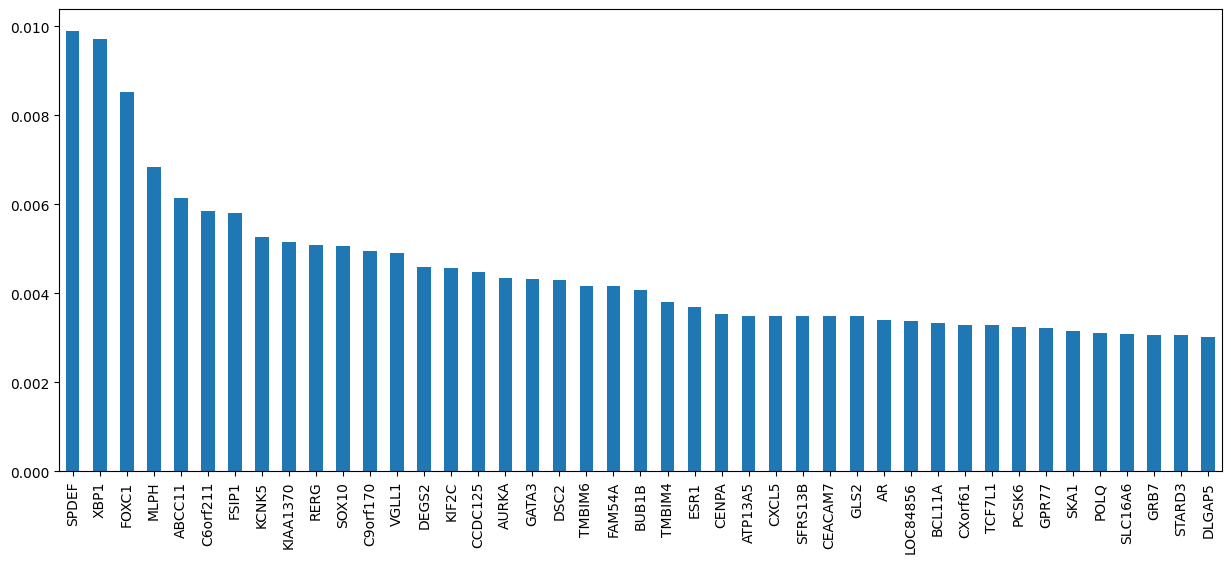

In [120]:
importance_subset = importance_df[importance_df.importance > 0.003]
importance_subset.index = [f.split(":")[3] for f in importance_df[importance_df.importance > 0.003].features]
importance = pd.Series(importance_subset.importance)

importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(15,6))

feature_list = importance_df[importance_df.importance > 0.003]['features'].tolist()
# [feature.split(":")[3] for feature in feature_list] # long tail distribution 

In [121]:
X_train_loo_new = X_train_loo[feature_list]
X_test_loo_new = X_test_loo[feature_list]

In [130]:
grid_search.fit(X_train_loo_new, y_train) # retran model using feature list (reducing noise)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_loo_new)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
float(rmse) # decreases

0.40482045237636816

In [131]:
",".join([feature.split(":")[3] for feature in feature_list]) # can demo pathways 

'SPDEF,XBP1,FOXC1,MLPH,ABCC11,C6orf211,FSIP1,KCNK5,KIAA1370,RERG,SOX10,C9orf170,VGLL1,DEGS2,KIF2C,CCDC125,AURKA,GATA3,DSC2,TMBIM6,FAM54A,BUB1B,TMBIM4,ESR1,CENPA,ATP13A5,CXCL5,SFRS13B,CEACAM7,GLS2,AR,LOC84856,BCL11A,CXorf61,TCF7L1,PCSK6,GPR77,SKA1,POLQ,SLC16A6,GRB7,STARD3,DLGAP5'

In [134]:
y_pred_proba = grid_search.best_estimator_.predict_proba(X_test_loo_new)

# evaluate the model - performs well on self (can utilize other resources ex. METABRIC)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("Model With feature list - New ROC AUC Score: ", roc_auc) # improves

Model With feature list - New ROC AUC Score:  0.9865547938201025


### Embedding per subtype 

In [ ]:
# todo.